In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

from scipy import stats
from scipy.stats import norm, skew

# A. Data Preprocessing

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

#Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

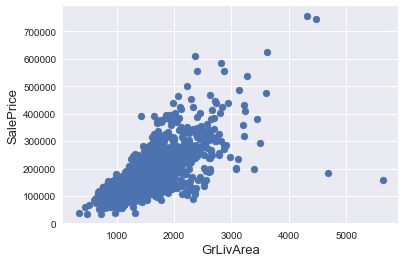

In [3]:
# outliers mentioned in the documentation

col1 = 'GrLivArea'
col2 = 'SalePrice'
plt.scatter(x = train[col1], y = train[col2])
plt.ylabel(col2, fontsize=13)
plt.xlabel(col1, fontsize=13)
plt.show()

In [4]:
#remove the two lower-right outliers:
train = train[train['GrLivArea'] < 4500]


 mu = 180932.92 and sigma = 79467.79



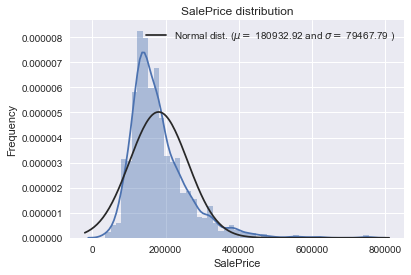

In [5]:
#analysis of target variable:
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')
plt.show()


 mu = 12.02 and sigma = 0.40



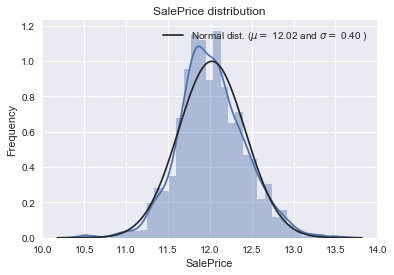

In [6]:
# apply log(x+1) to target variable and check distribution again:
train["SalePrice"] = np.log1p(train["SalePrice"])

sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')
plt.show()

In [7]:
# concatenate train and test sets to apply same preprocess on both

ntrain = train.shape[0]
ntest = test.shape[0]

y_train = train.SalePrice.values
train.drop(['SalePrice'], axis=1, inplace=True)

all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.shape

(2917, 79)

In [8]:
# 'Alley', 'Pool QC', 'Fence', 'Misc Feature', and 'fireplaceQu' have most values 'none'
# so we will remove them from the dataset and the test set. we also remove 'garageyrblt'
# as it seems as an irrelevant feature for the house price

all_data.drop(['Alley', 'PoolQC', 'PoolArea', 'Fence', 'MiscFeature', 
           'FireplaceQu', 'GarageYrBlt', 'Utilities'], axis=1, inplace=True)

## handling missing values:

In [9]:
# fill Lotfrontage by median of respective neighborhood:
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

# columns for which NA means 'None':
none_cols = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'MSSubClass',
             'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType']

# columns for which NA means zero:
zero_cols = ['BsmtFinSF1', 'BsmtFinSF2', 'GarageArea', 'GarageCars', 'BsmtUnfSF', 
            'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea']

all_data[none_cols] = all_data[none_cols].fillna('None')
all_data[zero_cols] = all_data[zero_cols].fillna(0)

# MSZoning (The general zoning classification) : 
#'RL' is by far the most common value. So we can fill in missing values with 'RL'

all_data['MSZoning'] = all_data['MSZoning'].fillna('RL')

In [10]:
# Functional : data description says NA means typical

all_data['Functional'] = all_data["Functional"].fillna('Typ')

# Electrical : It has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value.

all_data['Electrical'] = all_data['Electrical'].fillna('SBrkr')

# KitchenQual: Only one NA value, and same as Electrical, 
# we set 'TA' (which is the most frequent) for the missing value in KitchenQual.

all_data['KitchenQual'] = all_data['KitchenQual'].fillna('TA')

# Exterior1st and Exterior2nd : Again Both Exterior 1 & 2 have only one missing value. 
# We will just substitute in the most common string

all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

# SaleType : Fill in again with most frequent which is "WD"

all_data['SaleType'] = all_data['SaleType'].fillna('WD')

all_data.isnull().sum().sum()

0

## formating the data:

In [11]:
# Transforming some numerical variables that are really categorical:

#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)

#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [12]:
# Now we convert ordinal variables
dict1 = {'IR3':1, 'IR2':2, 'IR1':3, 'Reg':4}

all_data['LotShape'] = all_data['LotShape'].map(dict1)

dict1 = {'Sev':1, 'Mod':2, 'Gtl':3}

all_data['LandSlope'] = all_data['LandSlope'].map(dict1)

dict1 = {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5 }

all_data['ExterCond'] = all_data['ExterCond'].map(dict1)
all_data['ExterQual'] = all_data['ExterQual'].map(dict1)
all_data['KitchenQual'] = all_data['KitchenQual'].map(dict1)
all_data['HeatingQC'] = all_data['HeatingQC'].map(dict1)

In [13]:
dict1 = {'None':1, 'No':2, 'Mn':3, 'Av':4, 'Gd':5}

all_data['BsmtExposure'] = all_data['BsmtExposure'].map(dict1)

dict1 = {'None':1, 'Po':2, 'Fa':3, 'TA':4, 'Gd':5, 'Ex':6 }

all_data['BsmtQual'] = all_data['BsmtQual'].map(dict1)
all_data['BsmtCond'] = all_data['BsmtCond'].map(dict1)
all_data['GarageQual'] = all_data['GarageQual'].map(dict1)
all_data['GarageCond'] = all_data['GarageCond'].map(dict1)

dict1 = {'None':1, 'Unf':2, 'LwQ':3, 'Rec':4, 'BLQ':5, 'ALQ':6, 'GLQ':7}

all_data['BsmtFinType1'] = all_data['BsmtFinType1'].map(dict1)
all_data['BsmtFinType2'] = all_data['BsmtFinType2'].map(dict1)

dict1 = {'None':1, 'Unf':2, 'RFn':3, 'Fin':4}

all_data['GarageFinish'] = all_data['GarageFinish'].map(dict1)

In [14]:
dict1 = {'Mix':1, 'FuseP':2, 'FuseF':3, 'FuseA':4, 'SBrkr':5}

all_data['Electrical'] = all_data['Electrical'].map(dict1)

dict1 = {'Sal':1, 'Sev':2, 'Maj2':3, 'Maj1':4, 'Mod':5, 'Min2':6, 'Min1':7, 'Typ':8}

all_data['Functional'] = all_data['Functional'].map(dict1)

dict1 = {'N':1, 'P':2, 'Y':3}

all_data['PavedDrive'] = all_data['PavedDrive'].map(dict1)

dict1 = {'N':0, 'Y':1}

all_data['CentralAir'] = all_data['CentralAir'].map(dict1)

In [15]:
# Some feature engineering: 

# number of bathrooms:
all_data['Bathrooms'] = all_data['BsmtFullBath'] + all_data['BsmtHalfBath'] + all_data['FullBath'] + all_data['HalfBath']

# total area of bsmt, 1st and 2nd floor
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

# variable that indicates whether a house was built after 2000
def modern(x):
    if x >= 2000:
        x='Y'
    else:
        x='N'
    return x
all_data['IsModern'] = all_data['YearBuilt'].apply(modern)

In [16]:
# make a list of the names of numerical variables and categorical variables:

numerical_vars = all_data.dtypes[all_data.dtypes != "object"].index.values.tolist()
categorical_vars = all_data.dtypes[all_data.dtypes == "object"].index.values.tolist()

In [17]:
# taking care of skewed (numerical) variables with boxcox transformation:

skewed_vars = []
for column in numerical_vars:
    if np.abs(all_data[column].skew()) > 0.75:
        skewed_vars.append(column)
        
from scipy.special import boxcox1p
a = 0.15
for column in skewed_vars:
    all_data[column] = boxcox1p(all_data[column], a)

In [18]:
# get dummy variables:

all_data = pd.get_dummies(all_data).reset_index(drop=True)

In [19]:
# drop columns that have more than 99% zeros or ones after get_dummies:

overfit = []
for col in all_data.columns:
    top_value_count = all_data[col].value_counts().iloc[0]
    if top_value_count / all_data.shape[0] > 0.99:
        overfit.append(col)
        
all_data.drop(overfit, axis=1, inplace=True)
print(len(overfit))

68


In [20]:
# split to train and test set

train = all_data[:ntrain]
test = all_data[ntrain:]

print(train.shape, test.shape)

(1458, 171) (1459, 171)


# B. Modelling

In [21]:
# imports 

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline

## We will first set a baseline to benchmark our models, the baseline will be standard linear regression evaluated via 10-fold cross validation:

In [22]:
#Validation function
n_folds = 10

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [23]:
# rmsle of baseline:

lm = LinearRegression()
baseline = rmsle_cv(lm).mean()
print('The rmsle CV-score of LR is {:.7f}'.format(baseline))

# Predictions:
lm.fit(train, y_train)
y_pred = np.expm1(lm.predict(test))

sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = y_pred
sub.to_csv('lr_predictions.csv',index=False)
sub.head()

The rmsle CV-score of LR is 0.1172055


,Id,SalePrice
0,1461,105707.179919
1,1462,162118.705924
2,1463,179963.271186
3,1464,196040.338298
4,1465,206580.483026


In [24]:
# score on Kaggle:
LR_kaggle = 0.12115

# Lasso regression with gridsearch

In [25]:
lasso = Lasso(max_iter=10000)
scaler = StandardScaler()
robust = RobustScaler()

In [26]:
pipe = Pipeline([
    ('robust', robust),
    ('scaler', None),
    ('lasso', lasso)
])

grid_cv = GridSearchCV(pipe, [{
    'scaler': [scaler, None],
    'lasso__alpha': np.logspace(-6, 6, num=100),
}], cv=10, n_jobs=-1, scoring="neg_mean_squared_error")

grid_cv.fit(train.values, y_train)
grid_cv.best_params_

{'lasso__alpha': 0.0024770763559917113,
 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True)}

In [27]:
# Lets try again in a more restrictive space for alpha and scaler ON
pipe = Pipeline([
    ('robust', robust),
    ('scaler', scaler),
    ('lasso', lasso)
])

grid_cv = GridSearchCV(pipe, [{
    'lasso__alpha': np.logspace(-3, -2, num=100),
}], cv=10, n_jobs=-1, scoring="neg_mean_squared_error")

grid_cv.fit(train.values, y_train)
grid_cv.best_params_

{'lasso__alpha': 0.002595024211399737}

In [28]:
# so lets cross-validate our lasso model:

lasso = Lasso(alpha=0.0025, max_iter=10000)

pipe = Pipeline([
    ('robust', robust),
    ('scaler', scaler),
    ('lasso', lasso)
])

lasso_score = rmsle_cv(pipe).mean()
print('The rmsle CV-score of Lasso is {:.7f}'.format(lasso_score))

# Predictions:
pipe.fit(train, y_train)
y_pred = np.expm1(pipe.predict(test))

sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = y_pred
sub.to_csv('lasso_predictions.csv',index=False)
sub.head()

The rmsle CV-score of Lasso is 0.1115971


,Id,SalePrice
0,1461,118030.342203
1,1462,162149.674742
2,1463,180723.575130
3,1464,199412.134257
4,1465,206259.187319


In [29]:
# score on kaggle:
Lasso_kaggle = 0.11975

# Ridge regression with gridsearch

In [30]:
ridge = Ridge(max_iter=1000)

In [31]:
pipe = Pipeline([
    ('robust', robust),
    ('scaler', None),
    ('ridge', ridge)
])

grid_cv = GridSearchCV(pipe, [{
    'scaler': [scaler, None],
    'ridge__alpha': np.logspace(-6, 4, num=100),
}], cv=10, n_jobs=-1, scoring="neg_mean_squared_error")

grid_cv.fit(train.values, y_train)
grid_cv.best_params_

{'ridge__alpha': 9.326033468832199, 'scaler': None}

In [32]:
# Lets try again in a more restrictive space for alpha and no scaling
pipe = Pipeline([
    ('robust', robust),
    ('scaler', None),
    ('lasso', ridge)
])

grid_cv = GridSearchCV(pipe, [{
    'lasso__alpha': np.logspace(0, 2, num=100),
}], cv=10, n_jobs=-1, scoring="neg_mean_squared_error")

grid_cv.fit(train.values, y_train)
grid_cv.best_params_

{'lasso__alpha': 9.770099572992255}

In [33]:
# so lets cross-validate our ridge model:

ridge = Ridge(alpha=9.77, max_iter=1000)

pipe = Pipeline([
    ('robust', robust),
    ('lasso', ridge)
])

ridge_score = rmsle_cv(pipe).mean()
print('The rmsle CV-score of Ridge is {:.7f}'.format(ridge_score))

# Predictions:
pipe.fit(train, y_train)
y_pred = np.expm1(pipe.predict(test))

sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = y_pred
sub.to_csv('ridge_predictions.csv',index=False)
sub.head()

The rmsle CV-score of Ridge is 0.1119033


,Id,SalePrice
0,1461,112414.280269
1,1462,159883.159161
2,1463,179714.838879
3,1464,197342.793565
4,1465,201603.332851


In [34]:
# score on Kaggle:
Ridge_kaggle = 0.11906

## Lets see if by ensembling our Lasso and ridge models we can get a lower test error:

In [35]:
# We begin with this simple approach of ensembling two models. We build a new class to extend scikit-learn 
# with our model and also to laverage encapsulation and code reuse

from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

class EnsemblingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models, weight):
        self.models = models
        self.weight = weight
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return predictions[:,0] * self.weight + predictions[:,1] * (1 - self.weight)

In [36]:
ridge_pipe = Pipeline([
    ('robust', robust),
    ('lasso', Ridge(alpha=9.77, max_iter=1000))
])


lasso_pipe = Pipeline([
    ('robust', robust),
    ('scaler', scaler),
    ('lasso', Lasso(alpha=0.0025, max_iter=10000))
])

# grid search to find the best weight:
weights = np.arange(0, 1.01, 0.01)
cv_scores = []
for weight in weights:
    ensemble = EnsemblingModels(models = (ridge_pipe, lasso_pipe), weight=weight)
    cv_score = rmsle_cv(ensemble).mean()
    cv_scores.append(cv_score)
    
best_score = np.min(cv_scores)
best_weight = weights[np.argmin(cv_scores)]
print('the best CV score is {:.7f} achieved with weight={:.3f}'.format(best_score, best_weight))

the best CV score is 0.1111087 achieved with weight=0.440


In [37]:
ensemble = EnsemblingModels(models = (ridge_pipe, lasso_pipe), weight=best_weight)
# cross-validation and predictions:

ensemble_score = rmsle_cv(ensemble).mean()
print('The rmsle CV-score of the ensembled model is {:.7f}'.format(ensemble_score))

ensemble.fit(train, y_train)
y_pred = np.expm1(ensemble.predict(test))

sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = y_pred
sub.to_csv('ensemble_predictions.csv',index=False)
sub.head()

The rmsle CV-score of the ensembled model is 0.1111087


,Id,SalePrice
0,1461,115525.513418
1,1462,161148.476163
2,1463,180279.035496
3,1464,198498.964401
4,1465,204197.509400


In [38]:
# score on kaggle:
Ensemble_kaggle = 0.11889

# Recap:

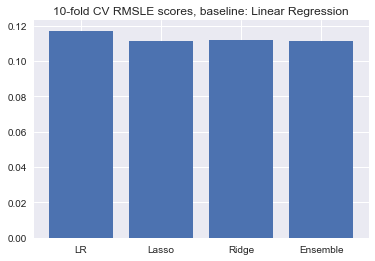

In [39]:
# Cross-validation RMSLE scores:

plt.bar([1, 2, 3, 4], [baseline, lasso_score, ridge_score, ensemble_score])
plt.xticks([1, 2, 3, 4], ['LR', 'Lasso', 'Ridge', 'Ensemble'])
plt.title('10-fold CV RMSLE scores, baseline: Linear Regression')
plt.show()

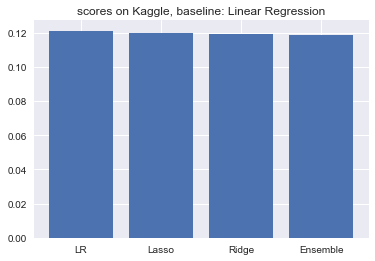

In [40]:
# Cross-validation RMSLE scores:

plt.bar([1, 2, 3, 4], [LR_kaggle, Lasso_kaggle, Ridge_kaggle, Ensemble_kaggle])
plt.xticks([1, 2, 3, 4], ['LR', 'Lasso', 'Ridge', 'Ensemble'])
plt.title('scores on Kaggle, baseline: Linear Regression')
plt.show()